###1.    Retrieve specific nutrient information (Twix caramel cookie bars) from the USDA DB

In [192]:
import urllib2
import threading
import pandas as pd
import json
import ast

import Keys

try:
    import xml.etree.cElementTree as ET
except ImportError:
    import xml.etree.ElementTree as ET

In [239]:
#serial implementation
def fetch_url(url):
    '''Simple function that reads any url string given as argument'''
    
    urlHandler = urllib2.urlopen(url)
    return urlHandler.read()
    
def nutrientFromdbno(dbno):
    '''Returns product nutrient table from the USDA database unique identifying number'''
    base = "https://api.nal.usda.gov/ndb/reports/?ndbno="
    more = "&type=f&format=json&api_key="
    url = base + dbno + more + Keys.usda_key
    data = fetch_url(url)   
    data = ast.literal_eval(data)
    data = pd.DataFrame.from_dict(data["report"]["food"]["nutrients"])
    data = data.loc[:,["group","name","unit","value"]]
    return data

def nutrientlists(query): 
    '''A function that takes a food product name and brief description and returns a table with nutritional 
    information on the specific product and all the related ones'''

    #product query and db number retrieval        
    query = urllib.quote_plus(query.lower())
    url = "https://api.nal.usda.gov/ndb/search/?format=xml&q=" + query + "&max=1500&offset=0&api_key=" + Keys.usda_key
    data = fetch_url(url) 
    root = ET.fromstring(data)
    #dbno = list(root)[0].find('ndbno').text #assume the 1st element correct. Ways to test that?
    #all related products
    dbno = [list(root)[i].find('ndbno').text for i in range(len(list(root)))]
    data = pd.DataFrame(columns = ['group','name','unit'])
    for no in dbno:
        datum = nutrientFromdbno(no)
        data = data.merge( datum, on=['group','name','unit'], how='outer')
    return data

def nutrientplot(dataframe):
    import seaborn as sns
    %pylab inline
    pylab.rcParams['figure.figsize'] = (10, 6)
    x = dataframe.ix[0,4:]
    x =[int(i) for i in pd.Series.tolist(x)]
    sns.distplot(x, rug=True);
    


Populating the interactive namespace from numpy and matplotlib


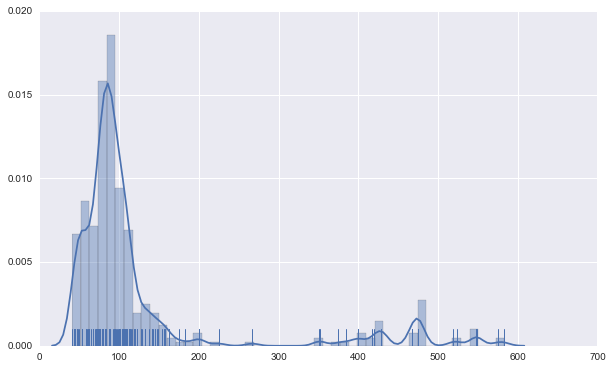

In [240]:
#resultS = nutrientlists("strawberry yogurt")
nutrientplot(resultS)

Populating the interactive namespace from numpy and matplotlib


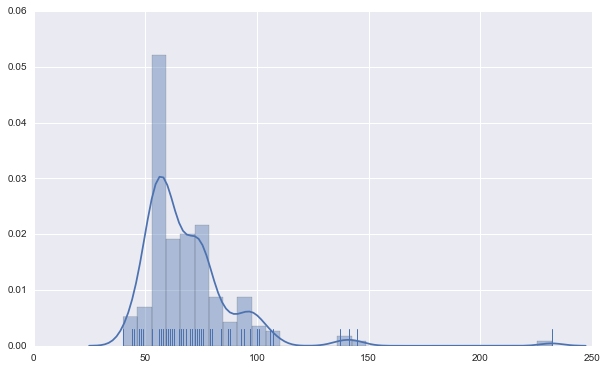

In [241]:
#resultP = nutrientlists("plain yogurt")
nutrientplot(resultP)

In [244]:
import scipy

x = resultS.ix[0,4:]
x =[int(i) for i in pd.Series.tolist(x)]
    
y = resultP.ix[0,4:]
y =[int(i) for i in pd.Series.tolist(y)]


scipy.stats.mannwhitneyu(x,y)

MannwhitneyuResult(statistic=15500.0, pvalue=4.8033070450573313e-25)

In [250]:
print "Strawberry yogurt has much higher calorific value than plain yougurt!"
print "Strawberry yogurt has on average "+ str(round(np.mean(x))) + " calories while plain yogurt only " + str(round(np.mean(y))) + "calories!"

Strawberry yogurt has much higher calorific value than plain yougurt!
Strawberry yogurt has on average 127.0 calories while plain yogurt only 69.0calories!


### Below here are test and attempts

In [237]:
resultP.head()

,group,name,unit,value_x,value_y,value_x,value_y,value_x,value_y,value_x,...,value_y,value_x,value_y,value_x,value_y,value_x,value_y,value_x,value_y,value
0,Proximates,Energy,kcal,53,71,141,106,47,106,63,...,75,75,60,97,101,62,79,60,87,79
1,Proximates,Protein,g,4.89,3.53,7.75,7.49,10.00,8.37,3.64,...,3.96,10.13,10.67,3.96,4.41,4.89,9.26,4.67,6.67,4.41
2,Proximates,Total lipid (fat),g,0.00,4.71,11.27,6.17,0.00,5.29,3.64,...,3.96,1.98,0.00,6.17,7.93,1.78,4.63,2.00,2.67,3.96
3,Proximates,"Carbohydrate, by difference",g,7.11,4.12,2.82,5.73,2.35,6.61,4.55,...,5.73,3.96,3.33,6.61,4.85,6.67,7.28,6.67,9.33,6.61
4,Proximates,"Fiber, total dietary",g,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,2.0,0.0


In [191]:
#This will be used as base for threading (fatsr request times)
def fetch_url(url):
    '''Function that reads the USDA product url string given as argument and returns its nutritional value'''
    
    urlHandler = urllib2.urlopen(url)
    return urlHandler.read()
    
def nutrientFromdbno(dbno):
    '''Returns product nutrient table from the USDA database unique identifying number'''
    
    base = "https://api.nal.usda.gov/ndb/reports/?ndbno="
    more = "&type=f&format=json&api_key="
    urls = [base + no + more + Keys.usda_key for no in dbno]
    threads = [threading.Thread(target=fetch_url, args=(url,)) for url in urls]
    url = base + dbno + more + Keys.usda_key
    data = fetch_url(url)   

    return data

def nutrientlists(query): 
    '''A function that takes a food product name and brief description and returns a table with nutritional 
    information on the specific product and all the related ones'''

    #product query and db number retrieval        
    query = urllib.quote_plus(query.lower())
    url = "https://api.nal.usda.gov/ndb/search/?format=xml&q=" + query + "&max=1500&offset=0&api_key=" + Keys.usda_key
    data = fetch_url(url) 
    root = ET.fromstring(data)
    dbno = list(root)[0].find('ndbno').text #assume the 1st element correct. Ways to test that?
    #all related products
    #dbno = [list(root)[i].find('ndbno').text for i in range(len(list(root)))]
    return nutrientFromdbno(dbno)
    


In [107]:
'''urllib2 threading is safe as long as the url is a string (otherwise use urllib3)
http://stackoverflow.com/questions/5825151/are-urllib2-and-httplib-thread-safe
and
http://stackoverflow.com/questions/27978190/multiple-requests-using-urllib2-urlopen-at-the-same-time
http://stackoverflow.com/questions/16181121/a-very-simple-multithreading-parallel-url-fetching-without-queue'''
import threading
import urllib2
import time

start = time.time()
urls = ["http://www.google.com", "http://www.apple.com", "http://www.microsoft.com", "http://www.amazon.com", "http://www.facebook.com"]

def fetch_url(url):
    urlHandler = urllib2.urlopen(url)
    html = urlHandler.read()
    print "'%s\' fetched in %ss" % (url, (time.time() - start))

threads = [threading.Thread(target=fetch_url, args=(url,)) for url in urls]
for thread in threads:
    thread.start()
for thread in threads:
    thread.join()

print "Elapsed Time: %s" % (time.time() - start)
threads

Exception in thread Thread-49:
Traceback (most recent call last):
  File "/Users/NikiAthanasiadou/anaconda2/envs/basic_env/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/Users/NikiAthanasiadou/anaconda2/envs/basic_env/lib/python2.7/threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "<ipython-input-107-cc5193ba2442>", line 14, in fetch_url
    urlHandler = urllib2.urlopen(url)
  File "/Users/NikiAthanasiadou/anaconda2/envs/basic_env/lib/python2.7/urllib2.py", line 154, in urlopen
    return opener.open(url, data, timeout)
  File "/Users/NikiAthanasiadou/anaconda2/envs/basic_env/lib/python2.7/urllib2.py", line 435, in open
    response = meth(req, response)
  File "/Users/NikiAthanasiadou/anaconda2/envs/basic_env/lib/python2.7/urllib2.py", line 548, in http_response
    'http', request, response, code, msg, hdrs)
  File "/Users/NikiAthanasiadou/anaconda2/envs/basic_env/lib/python2.7/urllib2.py", line 473, in error


'http://www.google.com' fetched in 0.102082014084s
'http://www.facebook.com' fetched in 0.384377002716s
'http://www.apple.com' fetched in 0.535503149033s
Elapsed Time: 0.535884141922


Exception in thread Thread-50:
Traceback (most recent call last):
  File "/Users/NikiAthanasiadou/anaconda2/envs/basic_env/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/Users/NikiAthanasiadou/anaconda2/envs/basic_env/lib/python2.7/threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "<ipython-input-107-cc5193ba2442>", line 14, in fetch_url
    urlHandler = urllib2.urlopen(url)
  File "/Users/NikiAthanasiadou/anaconda2/envs/basic_env/lib/python2.7/urllib2.py", line 154, in urlopen
    return opener.open(url, data, timeout)
  File "/Users/NikiAthanasiadou/anaconda2/envs/basic_env/lib/python2.7/urllib2.py", line 435, in open
    response = meth(req, response)
  File "/Users/NikiAthanasiadou/anaconda2/envs/basic_env/lib/python2.7/urllib2.py", line 548, in http_response
    'http', request, response, code, msg, hdrs)
  File "/Users/NikiAthanasiadou/anaconda2/envs/basic_env/lib/python2.7/urllib2.py", line 473, in error


[<Thread(Thread-47, stopped 123145332985856)>,
 <Thread(Thread-48, stopped 123145337192448)>,
 <Thread(Thread-49, stopped 123145341399040)>,
 <Thread(Thread-50, stopped 123145345605632)>,
 <Thread(Thread-51, stopped 123145349812224)>]

In [169]:
query = urllib.quote_plus("twix caramel cookie bars")
url = "https://api.nal.usda.gov/ndb/search/?format=xml&q=" + query + "&max=1500&offset=0&api_key=" + Keys.usda_key
data = fetch_url(url) 
root = ET.fromstring(data)
    #dbno = list(root)[0].find('ndbno').text #assume the 1st element correct. Ways to test that?
    #all related products
dbno = [list(root)[i].find('ndbno').text for i in range(len(list(root)))]
data = pd.DataFrame()

dat1 = nutrientFromdbno(dbno[0])
dat2 = nutrientFromdbno(dbno[6])


#dat1.set_index(['group','name','unit'])
data = dat1.merge( dat2, on=['group','name','unit'], how='outer')


In [170]:
data

,group,name,unit,value_x,value_y
0,Proximates,Water,g,4.230,NaN
1,Proximates,Energy,kcal,502.000,446
2,Proximates,Energy,kJ,2102.000,NaN
3,Proximates,Protein,g,4.910,21.43
4,Proximates,Total lipid (fat),g,24.850,16.07
5,Proximates,Ash,g,1.210,NaN
6,Proximates,"Carbohydrate, by difference",g,64.800,53.57
7,Proximates,"Fiber, total dietary",g,1.100,0.0
8,Proximates,"Sugars, total",g,48.250,35.71
9,Minerals,"Calcium, Ca",mg,106.000,143
